## This code is sd1.5 only

In [ ]:
# get pose images

In [1]:
!pip install mediapipe

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 78.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 28.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 77.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.5/77.5 MB 46.9 MB/s eta 0:00:0000:01:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.3/68.3 MB 42.8 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 58.7 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 3.6 MB/s eta 0:00:00


In [1]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from controlnet_aux import OpenposeDetector

# 動画の読み込み
video_path = 'hippop_720_1280_25fps.mp4'
cap = cv2.VideoCapture(video_path)

# フレーム抽出
frames = []
frame_rate = 25
extract_rate = 2  # 1秒間に2フレーム
total_frames = 16

for i in range(total_frames):
    frame_number = i * frame_rate // extract_rate
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    ret, frame = cap.read()
    if not ret:
        break
    frames.append(frame)

cap.release()

# フレームをリサイズ
resized_frames = []
target_short_side = 512

for frame in frames:
    height, width, _ = frame.shape
    if height < width:
        new_height = target_short_side
        new_width = int((target_short_side / height) * width)
    else:
        new_width = target_short_side
        new_height = int((target_short_side / width) * height)
    resized_frame = cv2.resize(frame, (new_width, new_height))
    resized_frames.append(resized_frame)

# ControlNet用ポーズ検出
pose_detector = OpenposeDetector.from_pretrained("lllyasviel/Annotators")

all_pose_images = []
for i, frame in enumerate(resized_frames):
    image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    poses = pose_detector(image)
    all_pose_images.append(poses)

    # 検出されたポーズを表示
    # plt.figure(figsize=(8, 8))
    # plt.imshow(poses)
    # plt.title(f'Frame {i+1}')
    # plt.show()


In [2]:
import torch
from diffusers import AutoencoderKL, ControlNetModel, MotionAdapter
from pipeline_animatediff_controlnet import AnimateDiffControlNetPipeline
from diffusers.schedulers import DPMSolverMultistepScheduler
from PIL import Image
from diffusers.utils import export_to_gif, export_to_video
import os

motion_id = "guoyww/animatediff-motion-adapter-v1-5-2"
adapter = MotionAdapter.from_pretrained(motion_id)
controlnet = ControlNetModel.from_pretrained("lllyasviel/control_v11p_sd15_openpose", torch_dtype=torch.float16)
vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-mse", torch_dtype=torch.float16)

model_id = "SG161222/Realistic_Vision_V5.1_noVAE"
pipe = AnimateDiffControlNetPipeline.from_pretrained(
    model_id,
    motion_adapter=adapter,
    controlnet=controlnet,
    vae=vae
    # custom_pipeline="pipeline_animatediff_controlnet",
).to(device="cuda", dtype=torch.float16)
pipe.scheduler = DPMSolverMultistepScheduler.from_pretrained(
    model_id, subfolder="scheduler", clip_sample=False, timestep_spacing="linspace", steps_offset=1, beta_schedule="linear", final_sigmas_type="sigma_min"
)
pipe.enable_vae_slicing()

prompt = "astronaut in space, dancing"
negative_prompt = "bad quality, worst quality, jpeg artifacts, ugly"
output = pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    width=512,
    height=920,
    conditioning_frames=all_pose_images,
    num_inference_steps=12,
)


frames = output.frames[0]
output_path = "generated/05_t2v_controlnet"
os.makedirs(os.path.dirname(output_path), exist_ok=True)
export_to_video(frames, output_path+".mp4")
export_to_gif(frames, output_path+".gif")

The config attributes {'motion_activation_fn': 'geglu', 'motion_attention_bias': False, 'motion_cross_attention_dim': None} were passed to MotionAdapter, but are not expected and will be ignored. Please verify your config.json configuration file.


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

The config attributes {'center_input_sample': False, 'flip_sin_to_cos': True, 'freq_shift': 0, 'mid_block_type': 'UNetMidBlock2DCrossAttn', 'only_cross_attention': False, 'attention_head_dim': 8, 'dual_cross_attention': False, 'class_embed_type': None, 'num_class_embeds': None, 'upcast_attention': False, 'resnet_time_scale_shift': 'default', 'resnet_skip_time_act': False, 'resnet_out_scale_factor': 1.0, 'time_embedding_type': 'positional', 'time_embedding_dim': None, 'time_embedding_act_fn': None, 'timestep_post_act': None, 'conv_in_kernel': 3, 'conv_out_kernel': 3, 'class_embeddings_concat': False, 'mid_block_only_cross_attention': None, 'cross_attention_norm': None, 'addition_embed_type_num_heads': 64} were passed to UNetMotionModel, but are not expected and will be ignored. Please verify your config.json configuration file.


  0%|          | 0/12 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


'generated/05_t2v_controlnet.gif'

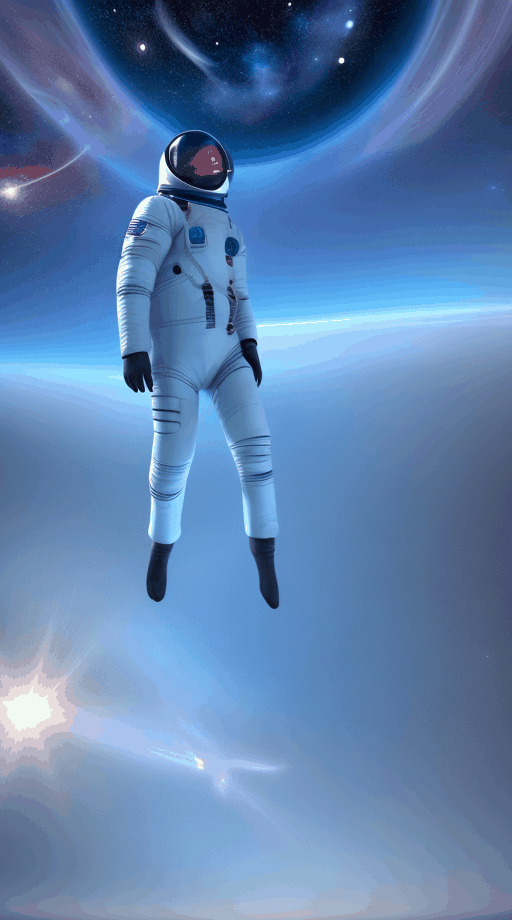

In [4]:
from IPython.display import Image

Image(output_path+".gif")

## In case of anime image

In [7]:
model_id = "sinkinai/anime-pastel-dream-soft-baked-vae"
pipe = AnimateDiffControlNetPipeline.from_pretrained(
    model_id,
    motion_adapter=adapter,
    controlnet=controlnet,
    vae=vae
    # custom_pipeline="pipeline_animatediff_controlnet",
).to(device="cuda", dtype=torch.float16)
pipe.scheduler = DPMSolverMultistepScheduler.from_pretrained(
    model_id, subfolder="scheduler", clip_sample=False, timestep_spacing="linspace", steps_offset=1, beta_schedule="linear", final_sigmas_type="sigma_min"
)
pipe.enable_vae_slicing()

prompt = "a girl in deep sea, dancing"
negative_prompt = "bad quality, worst quality, jpeg artifacts, ugly"
output = pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    width=512,
    height=920,
    conditioning_frames=all_pose_images,
    num_inference_steps=12
)


frames = output.frames[0]
output_path = "generated/05_t2v_controlnet_anime"
os.makedirs(os.path.dirname(output_path), exist_ok=True)
export_to_video(frames, output_path+".mp4")
export_to_gif(frames, output_path+".gif")

text_encoder/model.safetensors not found


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

The config attributes {'center_input_sample': False, 'flip_sin_to_cos': True, 'freq_shift': 0, 'mid_block_type': 'UNetMidBlock2DCrossAttn', 'only_cross_attention': False, 'attention_head_dim': 8, 'dual_cross_attention': False, 'class_embed_type': None, 'num_class_embeds': None, 'upcast_attention': False, 'resnet_time_scale_shift': 'default', 'time_embedding_type': 'positional', 'timestep_post_act': None, 'conv_in_kernel': 3, 'conv_out_kernel': 3, 'class_embeddings_concat': False} were passed to UNetMotionModel, but are not expected and will be ignored. Please verify your config.json configuration file.


  0%|          | 0/12 [00:00<?, ?it/s]

'generated/05_t2v_controlnet_anime.gif'

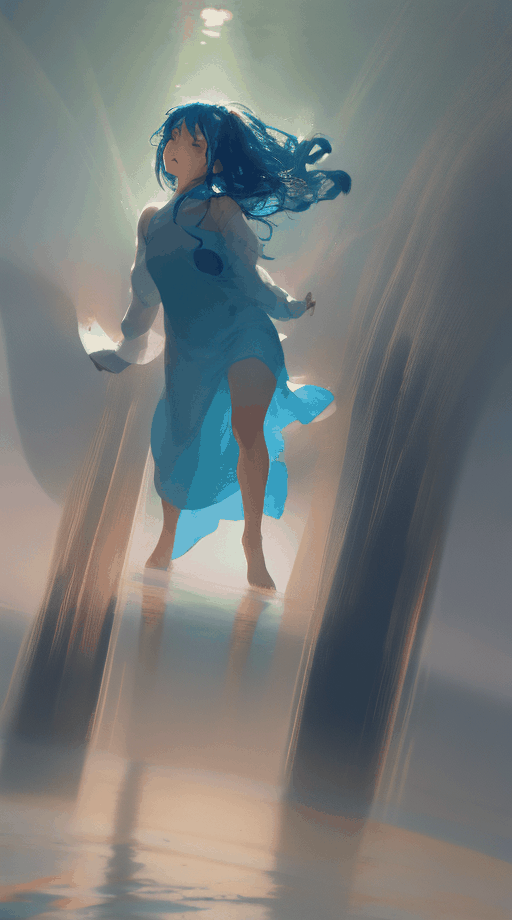

In [8]:
Image(output_path+".gif")

In [ ]:
## 12.7 GB -> 15.3GB